In [1]:
import os
import numpy as np
import pandas as pd
import math
from numba import njit
import open3d as o3d
import networkx as nx
import functools
import time
from matplotlib import pyplot as plt
from pytransform3d import rotations as pyro

In [2]:
def read_dat_sylinder( fname):
    # Read a SylinderAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Initialize numpy arrays for data
        gids = np.zeros( len(filecontent)-2, dtype=int)
        rad = np.zeros(len(filecontent)-2)
        pos0 = np.zeros( (len(filecontent)-2,3))
        pos1 = np.zeros( (len(filecontent)-2,3))
        ort = np.zeros( (len(filecontent)-2,3))

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []
        for idx,line in enumerate(filecontent):

            # Split the string with space-delimited and convert strings into useful data types
            data = line.split()
            gids[idx] = int(data[1])

            dat = np.array( list(map(float,data[2::])) )
            rad[idx] = dat[0]
            pos0[idx,:] = dat[1:4]
            pos1[idx,:] = dat[4::]
            xi = pos1[idx,:] - pos0[idx,:]
            ort[idx,:] =  xi/np.sqrt(xi.dot(xi))

    # Store data as a dataframe
    df = pd.DataFrame({
        'gid': gids,
        'radius' : rad,
        'pos0' : list(pos0),
        'pos1': list(pos1),
        'orientation': list(ort)
        })
    return df

def read_dat_protein( fname):
    # Read a ProetinAscii_X.dat file

    # open the file and read the lines
    with open(fname, 'r') as file1:
        filecontent = file1.readlines()

        # Delete the first two lines because they dont have any data
        filecontent[0:2] = []

        # Initialize numpy arrays for data
        gids = np.zeros( len(filecontent), dtype=int)
        pos0 = np.zeros( (len(filecontent),3))
        pos1 = np.zeros( (len(filecontent),3))
        link0 = np.zeros( len(filecontent), dtype=int)
        link1 = np.zeros( len(filecontent), dtype=int)

        for idx,line in enumerate(filecontent):

            # Split the string with space-delimited and convert strings into useful data types
            data = line.split()
            # pdb.set_trace()
            gids[idx] = int(data[1])
            link0[idx] = int(data[9])
            link1[idx] = int(data[10])
            dat = np.array( list(map(float,data[2:9])) )
            pos0[idx,:] = dat[1:4]
            pos1[idx,:] = dat[4::]

    # Store data as a dataframe
    df = pd.DataFrame({
        'gid': gids,
        'pos0' : list(pos0),
        'pos1': list(pos1),
        'link0': link0,
        'link1': link1
        })
    return df

In [120]:
def transform_coords( coords, origin_new, axis_new):
    # transform coordinates to a new frame of reference with the orivided
    # new origin and the the new basis matrix

    world_origin = np.array([0,0,0])
    world_vec = np.identity(3)

    # Translation vector
    T = (world_origin - origin_new)
    coords = coords + T.transpose()

    # Get vector perp to z-axis and the new z-axis
    vperp = pyro.perpendicular_to_vectors( world_vec[:,-1], axis_new)

    # Rotate if needed
    if np.linalg.norm( vperp) >0.00001:
        vperp = vperp / np.linalg.norm(vperp)
        theta = pyro.angle_between_vectors( world_vec[:,-1], obj_vec[:,-1])
        axis_angle = np.concatenate( (vperp, -np.array([theta]) ))
        q = pyro.quaternion_from_axis_angle( axis_angle)

        # transfrom coordinates
        coords = q_prod_coords( coords )

    return coords

@njit
def q_prod_coords( coords, q):
    # multiply each row vector in coords by the quaternion q
    for idx in np.arange( coords.shape[0]):
        t = 2 * np.cross(q[1:], coords[idx,:])
        coords[idx,:]+= q[0] * t + np.cross(q[1:], t)
    return coords

In [127]:
def timer( func):
    """ Print runtime of decorated functions """
    @functools.wraps( func)
    def wrapper_timer( *args, **kwargs):
        start_time = time.perf_counter()
        value = func( *args, **kwargs)
        end_time = time.perf_counter()
        run_time = end_time - start_time
        print(f"Finished {func.__name__!r} in {run_time:.4f} secs")
        return value
    return wrapper_timer

@timer
def calc_nematic_order(orient_array):
    # Calculates the maximum eigenvalue of the nematic tensor Q

    # calculate Q tensor
    Q = calc_nematic_tensor(orient_array)
    S = np.sqrt(np.tensordot(Q, Q)*1.5)
    return S

@timer
@njit
def calc_polar_order(orient_array):
    # Calculates the polar order given the array of filament orientations

    # Initialize P vector
    Pvec = np.zeros(3)

    # Take a mean of all orientations
    for irow in np.arange(orient_array.shape[0]):
        Pvec += orient_array[irow,:]
    Pvec = Pvec / orient_array.shape[0]
    P = np.linalg.norm( Pvec)
    return P

@njit
def calc_nematic_tensor( orient_array):
    # Calculates the nematic tensor Q

    # initialize Q tensor
    Q = np.zeros((3,3))
    # sum over all filaments, taking their outer products
    for irow in np.arange(orient_array.shape[0]):
        Q += np.outer( orient_array[irow,:], orient_array[irow,:])

    # complete mean calculation by dividing by number of filaments and subtracting identity.
    Q = Q/orient_array.shape[0] - np.identity(3)/3
    return Q


@timer
def get_largest_cc( nodes, edge0, edge1):
    # Get largesst connected component
    # nodes is a list of integers representing node indices
    # edge0 / edge1 are the list of nodes that each edge connects to.
    # Indices whose values are -1 are ignored in both edge0 and edge1.

    # Create a graph for filaments
    g = nx.Graph()
    g.add_nodes_from( nodes)

    # add edges to the graph
    for e0,e1 in zip( edge0,edge1):
        if e0 != -1 and e1 != -1:
            g.add_edge(e0, e1)

    # find connected component largest
    cc = list( max(nx.connected_components(g), key=len) )

    # also get a boolean array representing nodes that are in the largest cc
    cc_bool = np.zeros(len(nodes), dtype=bool)
    cc_bool[ cc] = True
    return cc, cc_bool

@timer
@njit
def get_edges_in_largest_cc( cc, edge0, edge1):

    # initialize
    idx_edges = []
    n_edges = 0

    # num xlinks in biggest cluster
    for idx in np.arange(len(edge0)):
        if edge0[idx] != -1 or edge1[idx] != -1:
            idx_edges.append( idx_edges)
            n_edges+=1

    return idx_edges, n_edges



@njit
def calc_distance_pbc(p0,p1,boxsize):
    # distance between two points in the nearest image convention
    # can use multidimensional arrays for distances between multiple points
    dist = np.absolute( p1-p0)
    for idx in np.arange(dist.shape[-1]):
        if len(dist.shape) == 1:
            k = np.floor( dist[idx]/(0.5*boxsize[idx]))
            dist[idx] -= k*boxsize[idx]
        elif len(dist.shape) == 2:
            k = np.floor( dist[:,idx]/(0.5*boxsize[idx]))
            dist[:,idx] -= k*boxsize[idx]
        # elif len(dist.shape) == 3:
            # k = np.floor( dist[:,:,idx]/(0.5*boxsize[idx]))
            # dist[:,:,idx] -= k*boxsize[idx]
    return np.absolute(dist)

@njit
def calc_mean_pbc(p0,p1,boxsize):
    # mean of the two points in the nearest image
    dist = np.absolute(p1-p0)
    for idx in np.arange(dist.shape[-1]):
        if len(dist.shape) == 1:
            k = np.floor( dist[idx]/(0.5*boxsize[idx]))
            p1[idx] -= k*boxsize[idx]
        elif len(dist.shape) == 2:
            k = np.floor( dist[:,idx]/(0.5*boxsize[idx]))
            p1[:,idx] -= k*boxsize[idx]
        # elif len(dist.shape) == 3:
            # k = np.floor( dist[:,:,idx]/(0.5*boxsize[idx]))
            # p1[:,:,idx] -= k*boxsize[idx]
    return (p0 + p1)/2

@timer
@njit
def calc_mean_separation(coords,boxsize):
    # Calculate mean pair-pair separation

    # Initialize
    num_coords = coords.shape[0]
    mu = 0
    sig = 0

    mean_p2p = calc_mean_p2p_dist( coords, boxsize)
    for idx in np.arange( num_coords):
        mu += mean_p2p[idx]
    mu = mu/num_coords
    sig = np.std( mean_p2p)
    return mu,sig


@njit
def calc_mean_p2p_dist(coords, boxsize):
    # Calculate mean separation of every filament from all other pairs

    # Initialize
    num_coords = coords.shape[0]
    mean_p2p = np.zeros( num_coords)

    # Calculate p2p distance matrix
    p2p_mat = calc_p2p_dist_mat(coords, boxsize)
    for idx in np.arange( num_coords):
        for idx2 in np.arange(num_coords):
            mean_p2p[idx] += p2p_mat[idx,idx2]
        mean_p2p[idx] = mean_p2p[idx]/num_coords

    return mean_p2p

@njit
def calc_p2p_dist_mat(coords, boxsize):

    # Initialize
    num_coords = coords.shape[0]
    p2p = np.zeros( (num_coords, num_coords))

    # Loop over reference filament. For ref filament,
    for jf in np.arange( num_coords):

        dist_sum = 0
        dist = np.absolute( coords[jf,:]-coords)

        # get distance to all other filaments
        for jf2 in np.arange( num_coords):

            # Skip if same as the reference filament
            if jf==jf2:
                continue
            # If distance with j1 and j2 switched already calculated, copy from matrix
            elif p2p[jf2,jf] != 0:
                p2p[jf,jf2] = p2p[jf2,jf]
                dist_sum += p2p[jf2,jf]
            # Otherwise, calculate distance
            else:
                # We need to find the norm distance. We will code up a manual
                # summation of squares and then take a square root. This is
                # faster with njit.
                # We apply box-size considerations to find the distance to the closest image
                dist_xyz = 0
                # get distance
                for idx in np.arange( len(boxsize)):
                    k = np.floor( dist[jf2,idx]/(0.5*boxsize[idx]))
                    dist[jf2,idx] -= k*boxsize[idx]
                    dist_xyz += dist[jf2,idx]**2
                p2p[jf,jf2] = np.sqrt( dist_xyz)
                dist_sum += p2p[jf,jf2]
    return p2p

@njit
def msd_pairs(lags,c,nT,nF,boxsize,boolRodsInside):
    mu = np.zeros(lags.shape)
    sig = np.zeros(lags.shape)
    for idx in range(lags.size):
        pptdiff = np.zeros(nT-lags[idx])
        for it in range(pptdiff.size):

            #find rods inside at both times
            rods_in = np.logical_and( boolRodsInside[it],boolRodsInside[it+lags[idx]])

            ppt1=dist2all(c[it,:,:],nT,nF,boxsize,rods_in)
            ppt2=dist2all(c[it+lags[idx],:,:],nT,nF,boxsize,rods_in)

            res = 0
            for idx2 in range(ppt1.size):
                res+=(ppt2[idx2]-ppt1[idx2])**2
            pptdiff[it] = res/ppt1.size
        mu[idx] = np.mean(pptdiff)
        sig[idx] = np.std(pptdiff)
    return mu,sig



@timer
@njit
def calc_protein_energy( lengths, rest_length):

    # Energy
    sum_energy = 0
    for ix in np.arange( len(lengths) ):
        sum_energy += 0.5*( lengths[ix]-rest_length)**2
    xlink_mu = sum_energy / lengths.shape[0]

    sum_energy_sq = 0
    for ix in np.arange( len(lengths) ):
        sum_energy_sq += ( 0.5*( lengths[ix]-rest_length)**2 - xlink_mu)
    xlink_std = np.sqrt( sum_energy_sq/lengths.shape[0])

    return xlink_mu, xlink_std


@timer
def calc_aspect_ratio( coords):
    # Calculate aspect ratio of bounding box of a collection of 3D points

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector( coords)
    obb = pcd.get_oriented_bounding_box()

    xx = obb.extent
    aspect_ratio = max( xx) / np.mean(sorted(xx)[0:2])
    return aspect_ratio

@timer
@njit
def calc_z_ordering( orient_array):
    # Calculate alignment in z

    z_axis = np.array( [0.,0.,1.])
    sum_all = 0
    for idx in np.arange( orient_array.shape[0]):
        sum_all += np.absolute( orient_array[idx,:].dot(z_axis) )
    return sum_all/orient_array.shape[0]


@njit
def pair_partition_func_centers(centers):
    
    q = np.zeros((centers.shape[0], centers.shape[0]))
    # for each pair of centers, calculate pair_partition function
    for idx1 in np.arange( centers.shape[0]):
        q[idx1,:] = pair_partition_func_i_centers( 
            centers[idx1,:], centers, q[idx1,:])
    return q

@njit
def pair_partition_func_i_centers(r0,r1,q):
    
    # distance between centers
    dist = r0-r1
    for idx in np.arange( dist.shape[1]):
        q+= dist[:,idx]**2
    return q


@timer
@njit
def calc_local_polar_order( c, orients, boxsize):
    # Calculate the local polar order
    
    porder_par = 0
    porder_apar = 0
    
    # Define a maximum distance for infinite square potential well
    dist_max = 4*0.025
    
    # coordinate indices within the distance range
    q = pair_partition_func_centers(c)

    for idx in np.arange( q.shape[0]):
        
        o_parallel = np.zeros(3)
        o_aparallel = np.zeros(3)
        n_parallel = 0
        n_aparallel = 0
        
        # orientation of reference filament
        o1 = orients[idx,:]
        for idx1 in np.arange(q.shape[1]):
            
            if o1.dot( orients[idx1,:]) > 0:
                o_parallel += q[idx,idx1]*orients[idx1,:]
                n_parallel += 1
            else:
                o_aparallel += q[idx,idx1]*orients[idx1,:]
                n_aparallel += 1
        
        porder_par += np.linalg.norm( o_parallel/n_parallel)
        porder_apar += np.linalg.norm( o_aparallel/n_aparallel)

    return porder_par/c.shape[0], porder_apar/c.shape[0]

@timer
def get_nodes_in_clusters( nodes, edge0, edge1, min_size_ratio=0.1):
    # Get largesst connected component
    # nodes is a list of integers representing node indices
    # edge0 / edge1 are the list of nodes that each edge connects to.
    # Indices whose values are -1 are ignored in both edge0 and edge1.

    # Create a graph for filaments
    g = nx.Graph()
    g.add_nodes_from( nodes)

    # add edges to the graph
    for e0,e1 in zip( edge0,edge1):
        if e0 != -1 and e1 != -1:
            g.add_edge(e0, e1)

    # find connected component largest
    cc_sort = sorted(nx.connected_components(g), key=len, reverse=True)
    cc_large = [ii for ii in cc_sort if len(ii) > 0.1*len(nodes)]
    cc = []
    for clus in cc_large:
        cc+=clus

    # also get a boolean array representing nodes that are in the largest cc
    cc_bool = np.zeros(len(nodes), dtype=bool)
    cc_bool[ cc] = True
    return cc, cc_bool



In [234]:
fpath = "/Users/saadjansari/Documents/Projects/Results/AMSOS/Tactoids/scan_filamin_6400/run/f10"
fpath_actin = os.path.join(fpath, "result/result0-399/SylinderAscii_100.dat")
fpath_xlinks = os.path.join(fpath, "result/result0-399/ProteinAscii_100.dat")

# fpath = "/Users/saadjansari/Documents/Projects/Results/AMSOS/Confinement/scan_d_pf_const_num/run/pf08_d125/merge"
# fpath_actin = os.path.join(fpath, "result/result400-799/SylinderAscii_660.dat")
# fpath_xlinks = os.path.join(fpath, "result/result400-799/ProteinAscii_660.dat")

df_sylinder = read_dat_sylinder(fpath_actin)
df_protein = read_dat_protein(fpath_xlinks)

In [235]:
import time
t0 = time.time()
boxsize=np.array([3.17,3.17,3.17])
data={}
# Filament centers
c = calc_mean_pbc(
    np.array( df_sylinder.pos0.tolist()),
    np.array( df_sylinder.pos1.tolist()),
    boxsize)

# Check existence of a cluster
# Get largest connected component using information about xlinks
cc, cc_bool = get_largest_cc(
        df_sylinder.gid.tolist(),
        df_protein.link0.tolist(),
        df_protein.link1.tolist() )
df_sylinder_cc = df_sylinder[cc_bool]


# Global order
# Bulk and Cluster
data['S_bulk'] = calc_nematic_order( np.array( df_sylinder.orientation.tolist()) )
data['P_bulk'] = calc_polar_order( np.array( df_sylinder.orientation.tolist()) )
data['S_cluster'] = calc_nematic_order( np.array( df_sylinder_cc.orientation.tolist()) )
data['P_cluster'] = calc_polar_order( np.array( df_sylinder_cc.orientation.tolist()) )

# Pair-pair separation

# Filament centers
c = calc_mean_pbc(
    np.array( df_sylinder.pos0.tolist()),
    np.array( df_sylinder.pos1.tolist()),
    boxsize)
# data['mean_sep_bulk'] = calc_mean_separation( c, boxsize)
data['mean_sep_cluster'] = list(calc_mean_separation( c[cc,:], boxsize))

# Xlink
# Energy
# xlink lengths
xlink_lengths = np.linalg.norm(
        calc_distance_pbc(
            np.array( df_protein.pos0.tolist()),
            np.array( df_protein.pos1.tolist()),
            boxsize), axis=1)
data['xlink_energy'] = list(calc_protein_energy( xlink_lengths, 0.05))

#data['tactoid_aspect_ratio'] = calc_aspect_ratio( c[cc,:])
data['z_order'] = calc_z_ordering( np.array( df_sylinder.orientation.tolist()) )
a,b = calc_local_polar_order( c, np.array( df_sylinder.orientation.tolist()),boxsize)

# Get nodes in clusters
cc, cc_bool = get_nodes_in_clusters(
        df_sylinder.gid.tolist(),
        df_protein.link0.tolist(),
        df_protein.link1.tolist(),
        min_size_ratio=0.1)

t1 = time.time()
print('Time elapsed = {}'.format(t1-t0))

Finished 'get_largest_cc' in 0.1152 secs
Finished 'calc_nematic_order' in 0.0026 secs
Finished 'calc_polar_order' in 0.0002 secs
Finished 'calc_nematic_order' in 0.0026 secs
Finished 'calc_polar_order' in 0.0001 secs
Finished 'calc_mean_separation' in 3.6119 secs
Finished 'calc_protein_energy' in 0.0002 secs
Finished 'calc_z_ordering' in 0.0002 secs
Finished 'calc_local_polar_order' in 7.4971 secs
Finished 'get_nodes_in_clusters' in 0.1074 secs
Time elapsed = 11.409334897994995


In [57]:
r0 = df_sylinder.pos0[0]
u0 = df_sylinder.orientation[0]
r1 = df_sylinder.pos0[1]
u1 = df_sylinder.orientation[1]

@njit
def pair_partition_func_centers(centers):
    
    q = np.zeros((centers.shape[0], centers.shape[0]))
    # for each pair of centers, calculate pair_partition function
    for idx1 in np.arange( centers.shape[0]):
        q[idx1,:] = pair_partition_func_i_centers( 
            centers[idx1,:], centers, q[idx1,:])
    return q

@njit
def pair_partition_func_i_centers(r0,r1,q):
    
    # distance between centers
    dist = r0-r1
    for idx in np.arange( dist.shape[1]):
        q+= dist[:,idx]**2
    return q

t0 = time.time()
q = pair_partition_func_centers(
    np.array( df_sylinder.pos0.tolist() ))
print('time elapsed = {}'.format(time.time()-t0))

time elapsed = 1.5853219032287598


In [224]:
def calc_cyl_corr_single( c_ref, c_all, axis_cyl):
    # calculates a binned (x^2+y^2) vs z binned matrix for distributions of points relative to reference point.

    # transform all other coordinates
#     c_tall = transform_coords(
#             c_all-c_ref,
#             np.array([0,0,0]),
#             axis_cyl)
    c_tall = c_all-c_ref
            

    x2y2sqrt = np.sqrt(
            c_tall[:,0]**2 + c_tall[:,1]**2 )
    z = c_tall[:,2]

    return x2y2sqrt, z

def calc_cyl_corr( c_all, axis_cyl):
    # calculates a binned (x^2+y^2) vs z binned matrix for all pairs of distributions of points

    sz = c_all.shape[0]
    xyall = np.zeros( sz**2)
    zall = np.zeros( sz**2)
    for idx in np.arange(sz):
        xyall[idx*sz:idx*sz+sz], zall[idx*sz:idx*sz+sz] = calc_cyl_corr_single(
                c_all[idx,:],
                c_all, axis_cyl)
    return xyall, zall

xy,z = calc_cyl_corr( c, np.array([0,0,1]) )

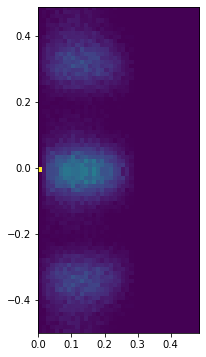

In [233]:
from matplotlib.image import NonUniformImage

xyedges = np.arange(0,0.5,0.0125)
zedges = np.arange(-0.5,0.5,0.0125)
W = np.outer( math.pi*(xyedges[1:]**2 - xyedges[:-1]**2), (zedges[1:]-zedges[:-1]) )
H,xyedges,zedges = np.histogram2d(xy,z, bins=(xyedges, zedges) )
H = H
fig,ax = plt.subplots(figsize=(14, 6))
plt.imshow(H.T, interpolation='nearest',
        extent=[xyedges[0], xyedges[-1], zedges[0], zedges[-1]])

In [163]:
c_all = c-c[0,:]
xyt = np.sqrt(
        c_all[:,0]**2 + c_all[:,1]**2 )
zt = c_all[:,2]


In [204]:
X.shape

(20, 10)

In [167]:
np.arange(0,1,0.05)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [191]:
H.shape

(9, 19)

In [189]:
(zedges[1:]-zedges[:-1])

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])

In [217]:
im

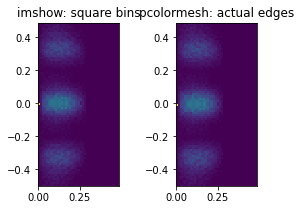

In [222]:
xedges = np.arange(0,0.5,0.0125)
yedges = np.arange(-0.5,0.5,0.0125)
W = np.outer( math.pi*(xedges[1:]**2 - xedges[:-1]**2), (yedges[1:]-yedges[:-1]) )

x = xy
y = z
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges))
H = H.T  # Let each row list bins with common y range.

fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(131, title='imshow: square bins')
plt.imshow(H, interpolation='nearest', origin='lower',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

ax = fig.add_subplot(132, title='pcolormesh: actual edges',
        aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)

# ax = fig.add_subplot(133, title='NonUniformImage: interpolated',
#         aspect='equal', xlim=xedges[[0, -1]], ylim=yedges[[0, -1]])
# im = NonUniformImage(ax, interpolation='bilinear')
# xcenters = (xedges[:-1] + xedges[1:]) / 2
# ycenters = (yedges[:-1] + yedges[1:]) / 2
# im.set_data(xcenters, ycenters, H)
# ax.images.append(im)
# plt.show()

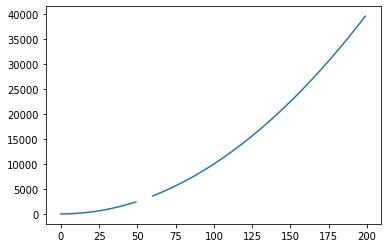

In [18]:
x = np.arange(200)
y = 1.0*x**2
y[50:60] = np.nan
plt.plot(x,y)

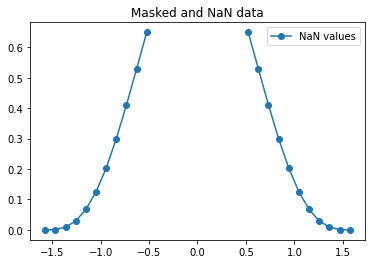

In [11]:
x = np.linspace(-np.pi/2, np.pi/2, 31)
y = np.cos(x)**3

# 3) set to NaN where y > 0.7
y4 = y.copy()
y4[y > 0.7] = np.nan

plt.plot(x*1.0, y4, 'o-', label='NaN values')
plt.legend()
plt.title('Masked and NaN data')
plt.show()

In [15]:
y[50]

2500